In [1]:
import tifffile as tiff
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations
from itertools import permutations
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, KDTree
from sklearn.cluster import KMeans
import cv2
from itertools import combinations
from sklearn.cluster import DBSCAN
import os
import tifffile as tiff


def is_close(point1, point2, gap):
    return np.linalg.norm(np.array(point1) - np.array(point2)) < gap

def calculate_angle(line):
    x1, y1, x2, y2 = line[0]
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def group_by_angle(lines, angle_threshold=5):
    angle_clusters = []
    for line in lines:
        angle = calculate_angle(line)
        added = False
        for cluster in angle_clusters:
            if abs(calculate_angle(cluster[0]) - angle) < angle_threshold:
                cluster.append(line)
                added = True
                break
        if not added:
            angle_clusters.append([line])
    return angle_clusters

def find_longest_line(cluster):
    points = set()
    for line in cluster:
        x1, y1, x2, y2 = line[0]
        points.add((x1, y1))
        points.add((x2, y2))
    
    max_dist = 0
    longest_line = None
    for (p1, p2) in combinations(points, 2):
        dist = np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)
        if dist > max_dist:
            max_dist = dist
            longest_line = [p1[0], p1[1], p2[0], p2[1]]
    
    return np.array([longest_line], dtype=np.int32)

def lines_intersect(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return False  # Lines are parallel and do not intersect
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator
    return min(x1, x2) <= intersect_x <= max(x1, x2) and min(x3, x4) <= intersect_x <= max(x3, x4) and \
           min(y1, y2) <= intersect_y <= max(y1, y2) and min(y3, y4) <= intersect_y <= max(y3, y4)

def merge_lines_by_angle(lines, gap=0, angle_threshold=1):
    if len(lines) <= 1:
        return lines  # Return the single line or an empty list

    # Group lines by angle
    angle_clusters = group_by_angle(lines, angle_threshold)

    # Find the cluster with the most lines
    largest_cluster = max(angle_clusters, key=len)

    return largest_cluster

def find_intersection(horizontal_line, vertical_line):
    x1, y1, x2, y2 = horizontal_line[0]
    x3, y3, x4, y4 = vertical_line[0]
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return None  # Lines are parallel and do not intersect
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator
    return (int(intersect_x), int(intersect_y))

def calculate_area(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    x4, y4 = points[3]
    return 0.5 * abs(x1*y2 + x2*y3 + x3*y4 + x4*y1 - y1*x2 - y2*x3 - y3*x4 - y4*x1)


def calculate_angle_between_lines(p1, p2, p3):
    a = np.array(p1) - np.array(p2)
    b = np.array(p3) - np.array(p2)
    cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

def is_square(points, angle_tolerance=10):
    angles = []
    for i in range(4):
        angles.append(calculate_angle_between_lines(points[i], points[(i + 1) % 4], points[(i + 2) % 4]))
    return all(90 - angle_tolerance <= angle <= 90 + angle_tolerance for angle in angles)

def calculate_center(cluster):
    return np.mean(cluster, axis=0).astype(int)

def calculate_angle(center, point):
    return np.arctan2(point[1] - center[1], point[0] - center[0])

def angles_approx_equal(angle1, angle2, tolerance=np.pi/90): 
    return np.abs(angle1 - angle2) < tolerance

---

# Code for extract field

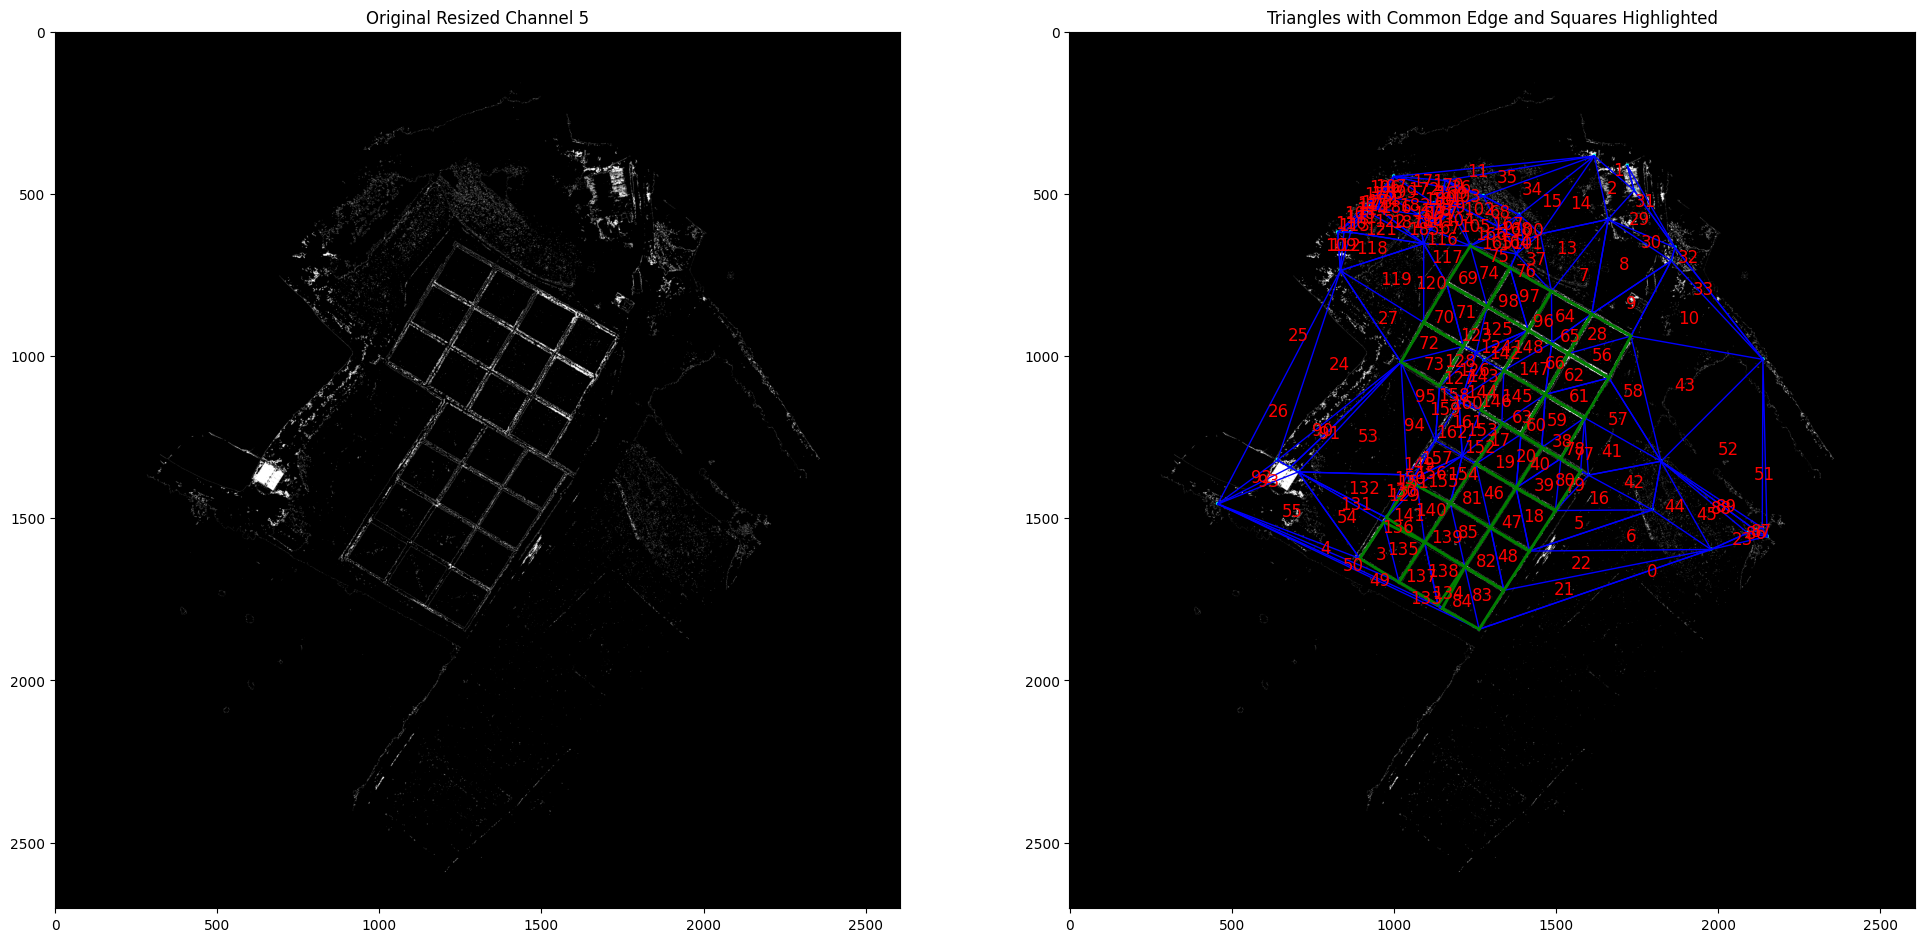

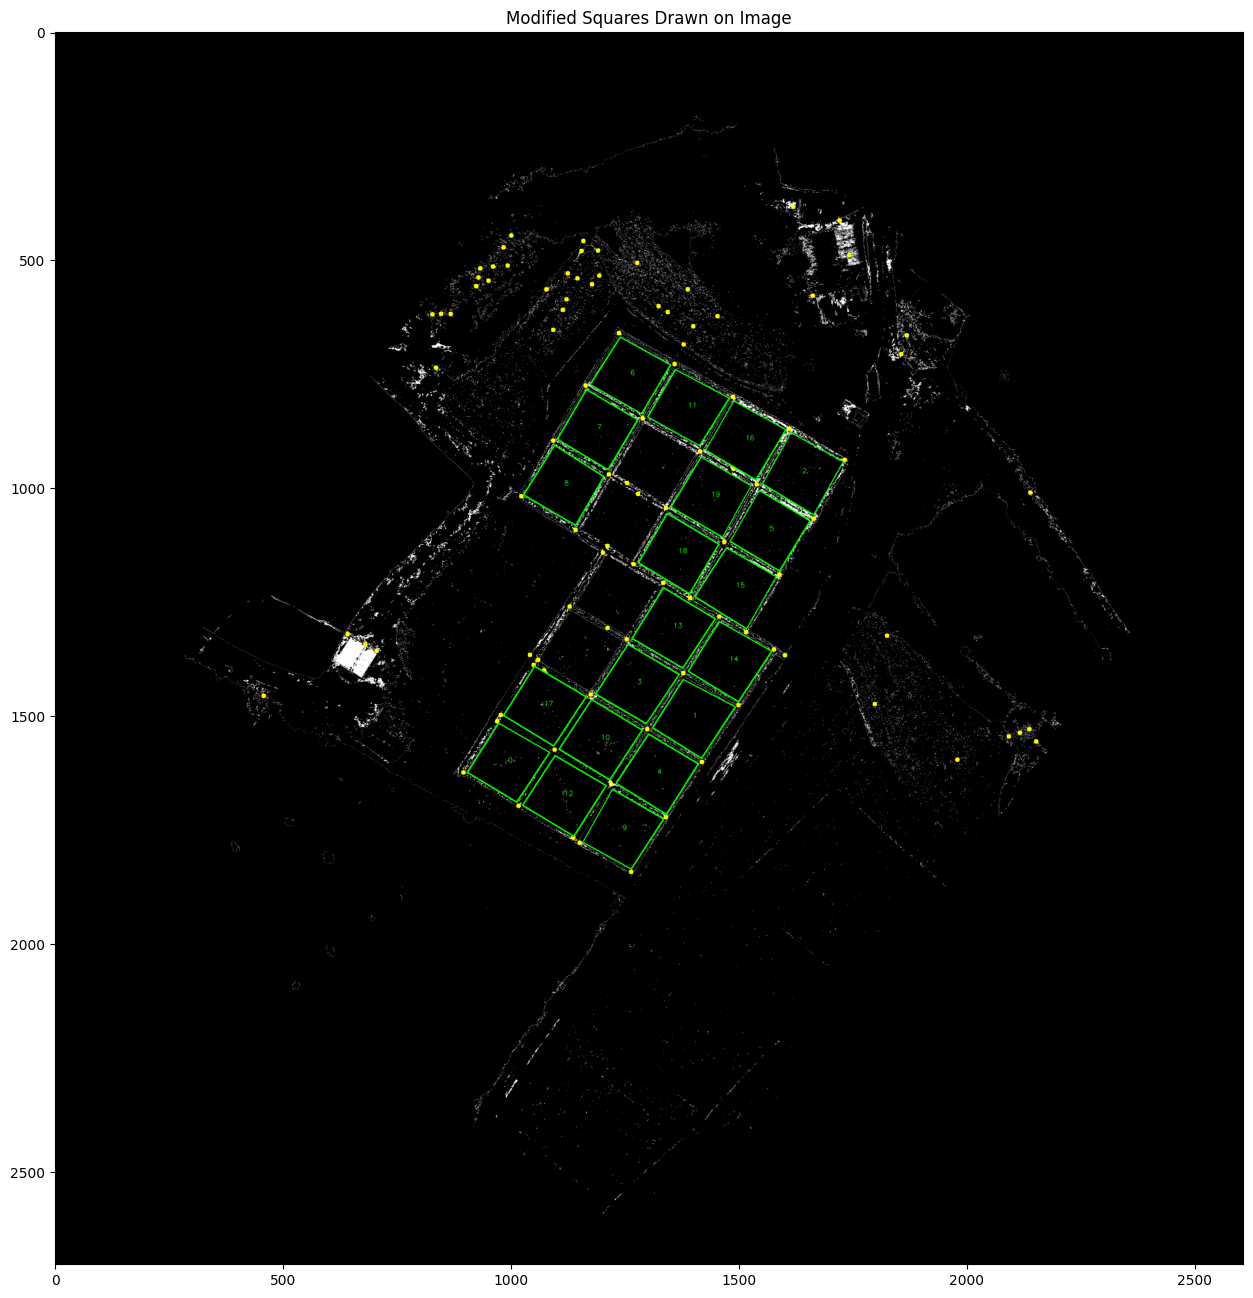

Cropping and saving completed.
CSV file creation completed.


C:\Users\longh\AppData\Local\Temp\ipykernel_7724\900987162.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


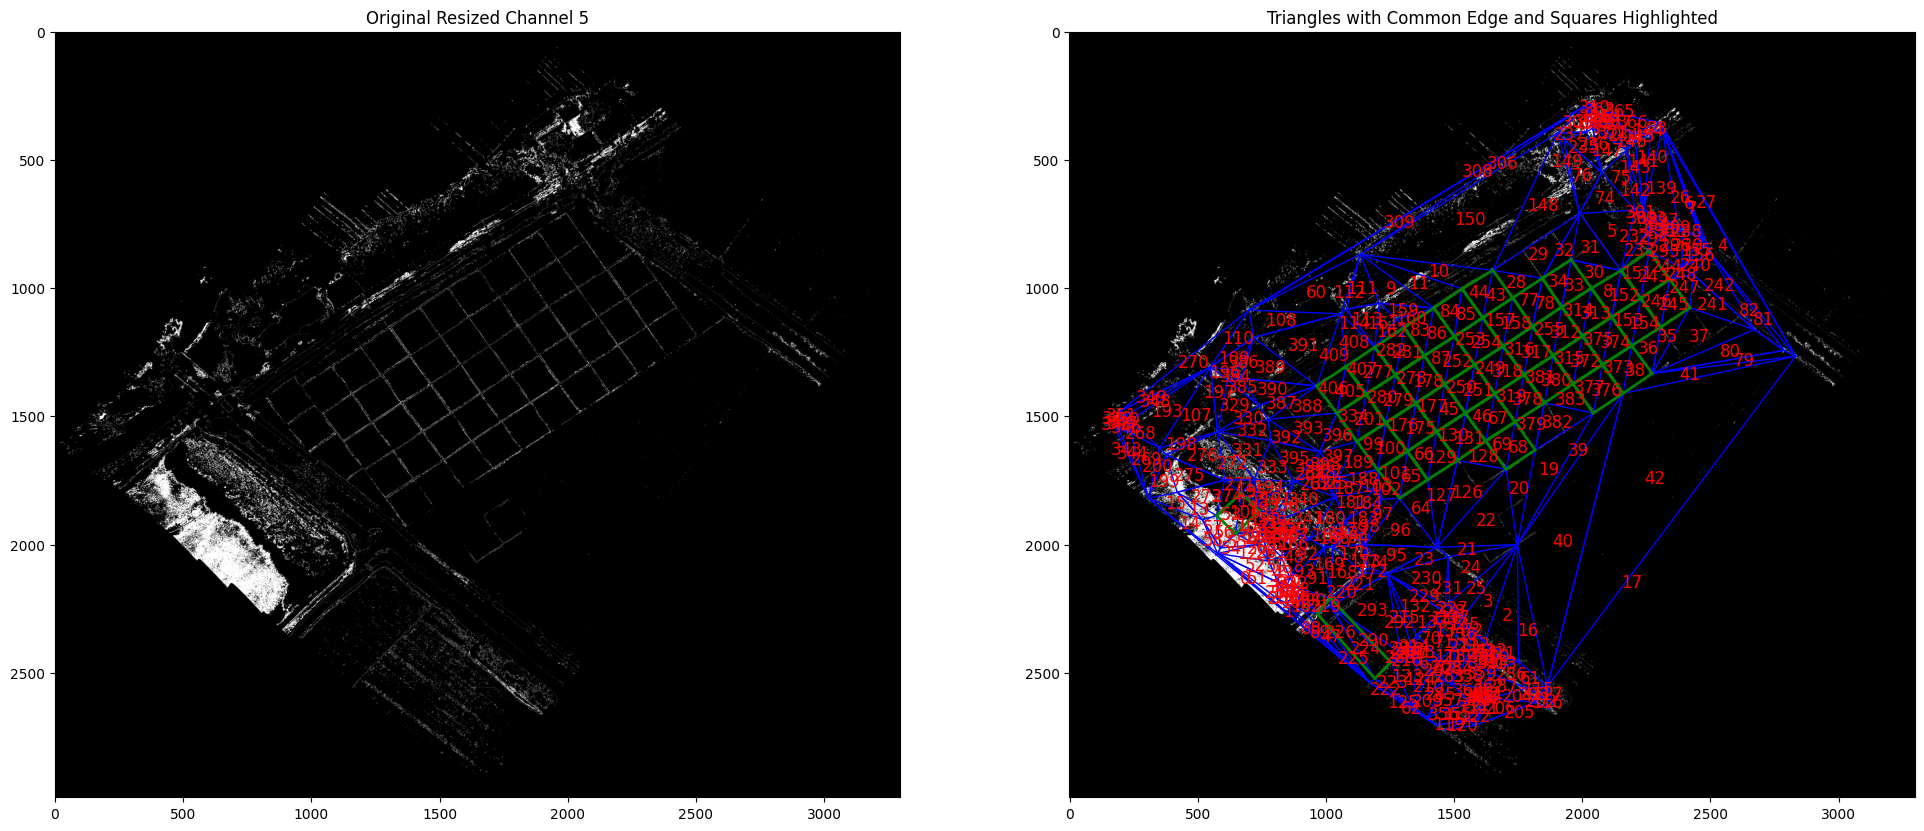

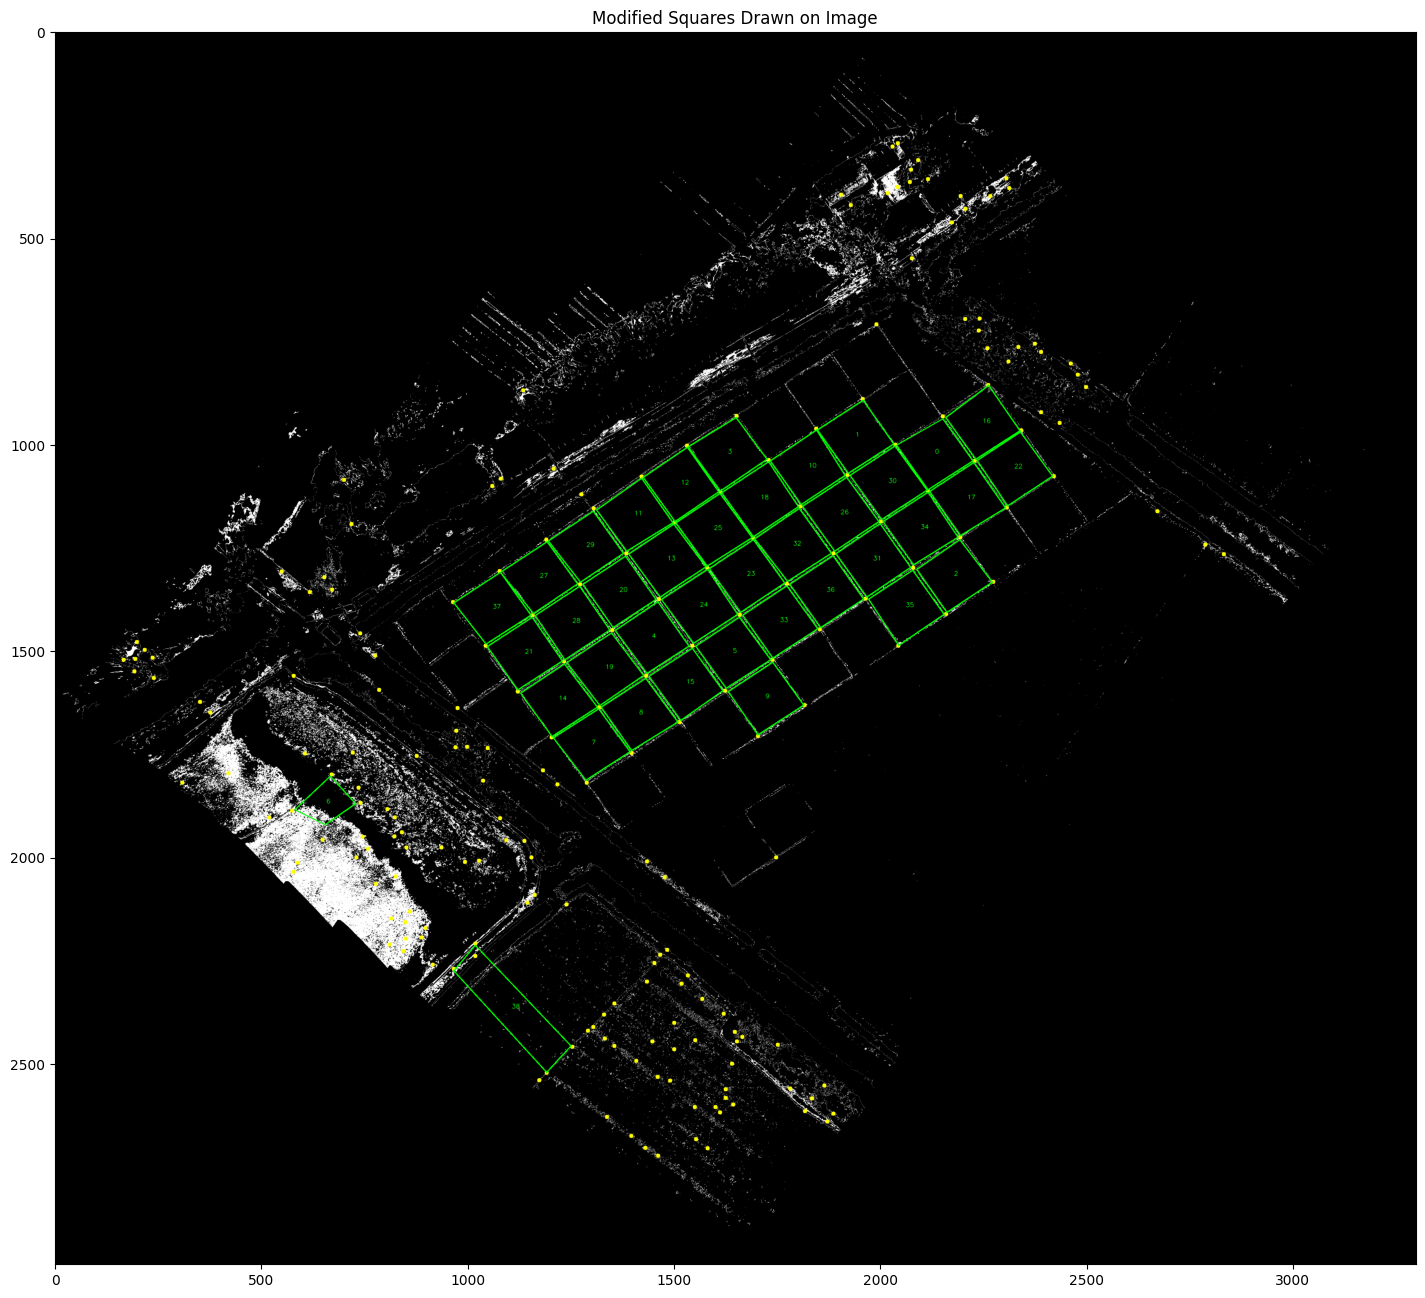

Cropping and saving completed.
CSV file creation completed.


65770

In [20]:
def process_tiff_file(file_path):
    if os.path.exists(file_path):
        try:
            tif_image = tiff.imread(file_path)
            if tif_image is not None and tif_image.ndim == 3 and tif_image.shape[2] >= 5:
                channel_5 = tif_image[:, :, 4]
                if channel_5.dtype != np.uint8:
                    channel_5 = cv2.normalize(channel_5, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

                cropped_channel_5 = channel_5
                target_color = 7
                mask = cv2.inRange(cropped_channel_5, target_color, target_color)

                scale_percent = 50
                width = int(mask.shape[1] * scale_percent / 100)
                height = int(mask.shape[0] * scale_percent / 100)
                dim = (width, height)
                resized_mask = cv2.resize(mask, dim, interpolation=cv2.INTER_AREA)

                blurred_mask = cv2.GaussianBlur(resized_mask, (5, 5), 1.1)
                edges = cv2.Canny(blurred_mask, 50, 100)

                kernel = np.ones((5, 5), np.uint8)
                dilated_edges = cv2.dilate(edges, kernel, iterations=1)
                eroded_edges = cv2.erode(dilated_edges, kernel, iterations=1)

                lines = cv2.HoughLinesP(eroded_edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

                horizontal_lines = []
                vertical_lines = []
                if lines is not None:
                    for line in lines:
                        if len(line[0]) == 4:  # Ensure the line has 4 values
                            x1, y1, x2, y2 = line[0]
                            if abs(y2 - y1) < abs(x2 - x1):
                                horizontal_lines.append(line)
                            else:
                                vertical_lines.append(line)

                intersection_points = []
                for h_line in horizontal_lines:
                    for v_line in vertical_lines:
                        if lines_intersect(h_line, v_line):
                            intersection_points.append(find_intersection(h_line, v_line))

                # Clustering intersection points
                intersection_points = np.array(intersection_points)
                db = DBSCAN(eps=10, min_samples=4).fit(intersection_points)
                labels_point = db.labels_
                unique_labels = set(labels_point)
                intersection_points_clusters = [intersection_points[labels_point == k] for k in unique_labels if k != -1]

                # Highlight clusters
                line_image = np.copy(resized_mask)
                line_image = cv2.cvtColor(line_image, cv2.COLOR_GRAY2BGR)
                
                cluster_centers = []
                for cluster in intersection_points_clusters:
                    center = calculate_center(cluster)
                    cluster_centers.append(center)
                    cv2.circle(line_image, tuple(center), 5, (0, 255, 255), -1)  # Draw center in yellow

                # Convert cluster_centers to numpy array
                cluster_centers = np.array(cluster_centers)

                # Perform Delaunay triangulation
                tri = Delaunay(cluster_centers)

                # Plot the triangles and squares
                plt.figure(figsize=(24, 16), num=2)
                plt.subplot(1, 2, 1)
                plt.title('Original Resized Channel 5')
                plt.imshow(resized_mask, cmap='gray')

                plt.subplot(1, 2, 2)
                plt.title('Triangles with Common Edge and Squares Highlighted')
                plt.imshow(line_image)

                for idx, triangle in enumerate(tri.simplices):
                    plt.plot(cluster_centers[triangle, 0], cluster_centers[triangle, 1], 'b-', lw=1)
                    # Calculate centroid of the triangle to annotate
                    centroid = np.mean(cluster_centers[triangle], axis=0)
                    plt.text(centroid[0], centroid[1], str(idx), fontsize=12, ha='center', va='center', color='r')

                squares = []
                square_count = 0

                # Find and draw all squares formed by triangles with a common edge
                triangles_to_remove = set()

                for i, triangle1 in enumerate(tri.simplices):
                    if i in triangles_to_remove:
                        continue
                    for j, triangle2 in enumerate(tri.simplices):
                        if i < j:  # Ensure we're not checking the same pair twice
                            common_vertices = set(triangle1).intersection(set(triangle2))

                            if len(common_vertices) == 2:  # Triangles share an edge
                                common_vertices = list(common_vertices)
                                triangle1_vertices = list(set(triangle1) - set(common_vertices))
                                triangle2_vertices = list(set(triangle2) - set(common_vertices))
                                
                                square_vertices = triangle1_vertices + [common_vertices[0]] + triangle2_vertices + [common_vertices[1]]
                                
                                if is_square(cluster_centers[square_vertices]):
                                    squares.append(square_vertices)
                                    triangles_to_remove.update([i, j])

                for i, triangle1 in enumerate(tri.simplices):
                    if i in triangles_to_remove:
                        continue
                    for j, triangle2 in enumerate(tri.simplices):
                        if j in triangles_to_remove:
                            continue
                        if i != j:
                            common_vertices_1_2 = set(triangle1).intersection(set(triangle2))
                            if len(common_vertices_1_2) == 2:
                                for k, triangle3 in enumerate(tri.simplices):
                                    if k in triangles_to_remove:
                                        continue
                                    if k != i and k != j:
                                        common_vertices_1_3 = set(triangle1).intersection(set(triangle3))
                                        if len(common_vertices_1_3) == 2:
                                            common_point = set(common_vertices_1_2).intersection(set(common_vertices_1_3))
                                            
                                            tri2_verticle = list(set(triangle2) - set(common_vertices_1_2))
                                            tri3_verticle = list(set(triangle3) - set(common_vertices_1_3))
                                            tri31_verticle = list(set(common_vertices_1_3) - set(common_point))
                                            tri21_verticle = list(set(common_vertices_1_2) - set(common_point))

                                            square_vertices = tri2_verticle + tri3_verticle + tri31_verticle + tri21_verticle
                                            
                                            if is_square(cluster_centers[np.array(square_vertices)]):
                                                squares.append(square_vertices)
                                                triangles_to_remove.update([i, j, k])
                                                square_count += 1

                square_areas = [calculate_area(cluster_centers[np.array(square)]) for square in squares]
                square_areas = np.array(square_areas).reshape(-1, 1)

                n_clusters = 3
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(square_areas)
                labels = kmeans.labels_

                colors = ['m', 'y', 'k', 'r', 'g', 'b', 'c']
                cluster_counts = np.bincount(labels)
                most_common_cluster = np.argmax(cluster_counts)

                selected_squares = [square for idx, square in enumerate(squares) if labels[idx] == most_common_cluster]

                for square in selected_squares:
                    for l in range(4):
                        plt.plot([cluster_centers[square[l], 0], cluster_centers[square[(l + 1) % 4], 0]],
                                                                [cluster_centers[square[l], 1], cluster_centers[square[(l + 1) % 4], 1]], 'g-', lw=2)

                square_after_modified = []
                for square in selected_squares:
                    modified_square = []
                    center = calculate_center([cluster_centers[idx] for idx in square])
                    for index in square:
                        point = cluster_centers[index]
                        cluster = intersection_points_clusters[index]
                        cluster_center = calculate_center(cluster)
                        center_angle = calculate_angle(center, point)
                        
                        closest_point = point
                        min_distance = np.linalg.norm(closest_point - center)
                        
                        for candidate_point in cluster:
                            distance = np.linalg.norm(candidate_point - center)
                            candidate_angle = calculate_angle(center, candidate_point)
                            
                            if angles_approx_equal(center_angle, candidate_angle) and distance < min_distance :
                                min_distance = distance
                                closest_point = candidate_point

                        modified_square.append(closest_point)
                    square_after_modified.append(modified_square)

                for i, square in enumerate(square_after_modified):
                    center = calculate_center(square)
                    cv2.putText(line_image, str(i), tuple(center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

                    for l in range(4):
                        pt1 = tuple(square[l])
                        pt2 = tuple(square[(l + 1) % 4])
                        cv2.line(line_image, square[l], square[(l + 1) % 4], (0, 255, 0), 2)

                plt.figure(figsize=(24, 16))
                plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
                plt.title('Modified Squares Drawn on Image')
                plt.show()

                return square_after_modified, tif_image

            else:
                print("Error: The image does not have at least five channels or could not be read.")
        except Exception as e:
            print(f"Error reading the TIFF file: {e}")
    else:
        print(f"Error: File '{file_path}' does not exist.")


---
# Seperate image

Cut image and create mask for each square

In [23]:
def cut_square(square_after_modified, cropped_channel_5, file_name_prefix, csv_writer, global_id_start):
    output_folder = os.path.join("cropped_images", file_name_prefix)
    os.makedirs(output_folder, exist_ok=True)
    max_size_x = 416
    max_size_y = 384
    current_id = global_id_start

    for i, square in enumerate(square_after_modified):
        x_coords = [pt[0] for pt in square]
        y_coords = [pt[1] for pt in square]
        x_min, x_max = min(x_coords) * 2, max(x_coords) * 2
        y_min, y_max = min(y_coords) * 2, max(y_coords) * 2

        cropped_image = cropped_channel_5[y_min:y_max, x_min:x_max, :5]
        output_path = os.path.join(output_folder, f"cropped_image_{i}.tiff")
        tiff.imwrite(output_path, np.transpose(cropped_image, (2, 0, 1)))

        # Create mask
        square_mask = []

        for point in square:
            square_mask.append([point[0] * 2 - x_min, point[1] * 2 - y_min])
        
        mask = np.zeros(cropped_image.shape[:2], dtype=np.uint8)
        pts = np.array(square_mask, np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], 255)
        
        # Save the mask image
        mask_output_path = os.path.join(output_folder, f"mask_image_{i}.jpg")
        cv2.imwrite(mask_output_path, mask)

        # Write to global CSV file
        image_output_path = f"/kaggle/input/cropped-field/cropped_images/cropped_images/{file_name_prefix}/cropped_image_{i}.tiff"
        mask_output_path_csv = f"/kaggle/input/cropped-field/cropped_images/cropped_images/{file_name_prefix}/mask_image_{i}.jpg"
        fold_value = 0
        if i > 3:
            fold_value = 1
        csv_writer.writerow([current_id, image_output_path, mask_output_path_csv, False, ", ,", "0", fold_value])
        current_id += 1

    print("Cropping and saving completed.")
    return current_id




C:\Users\longh\AppData\Local\Temp\ipykernel_7724\900987162.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


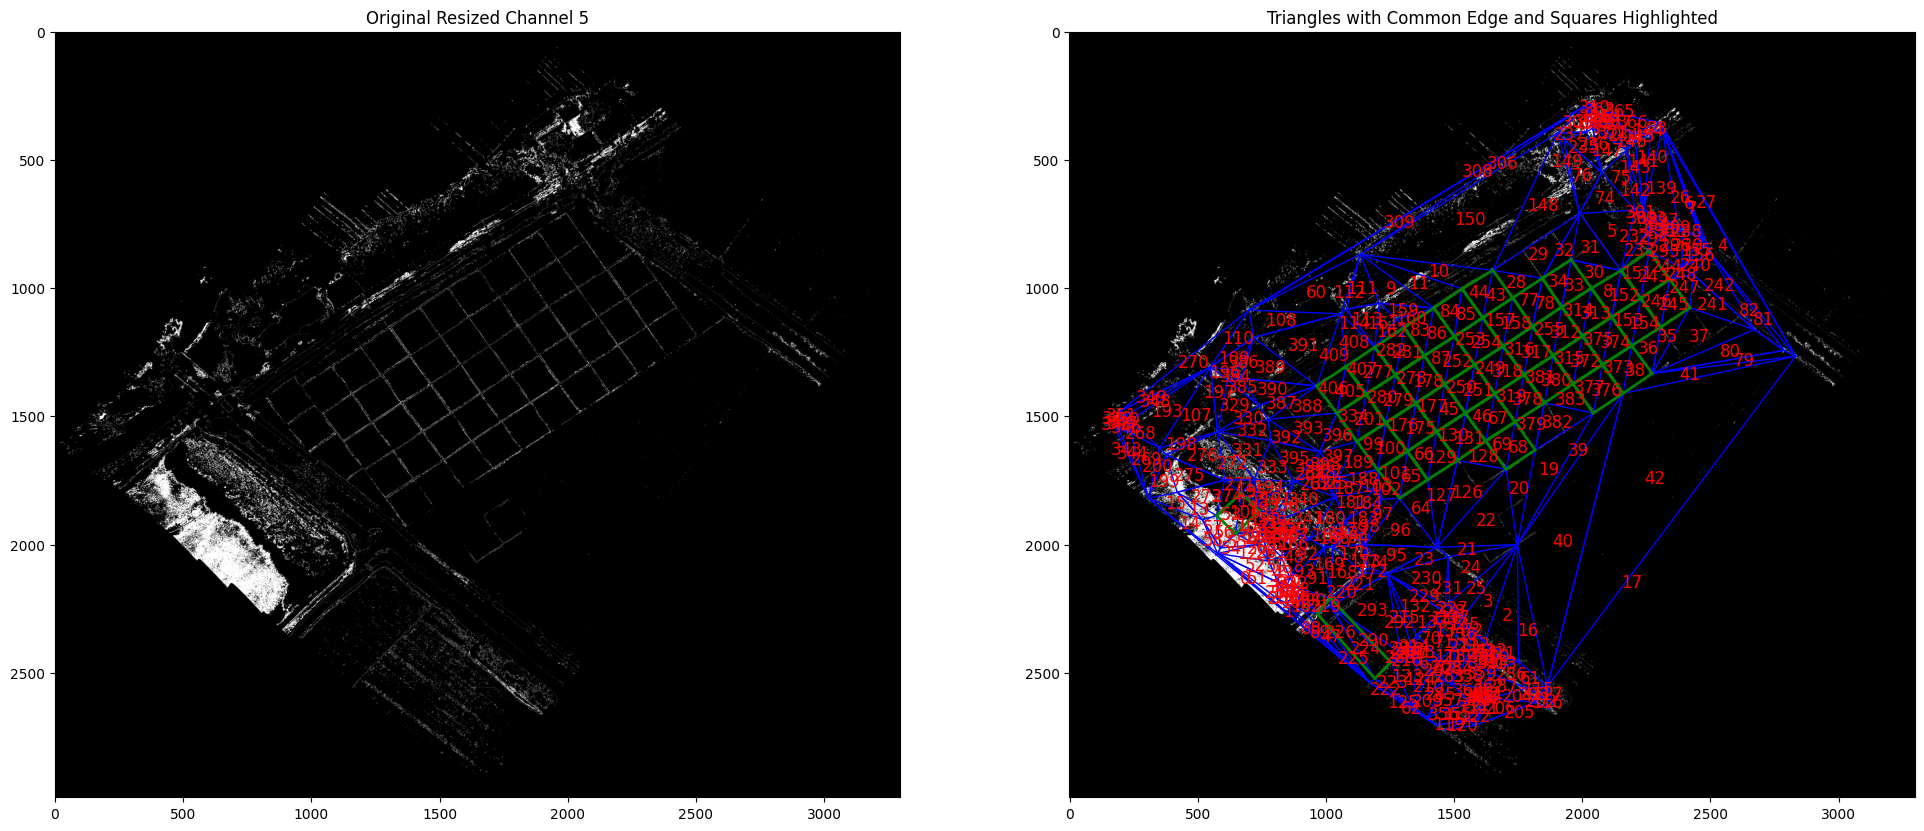

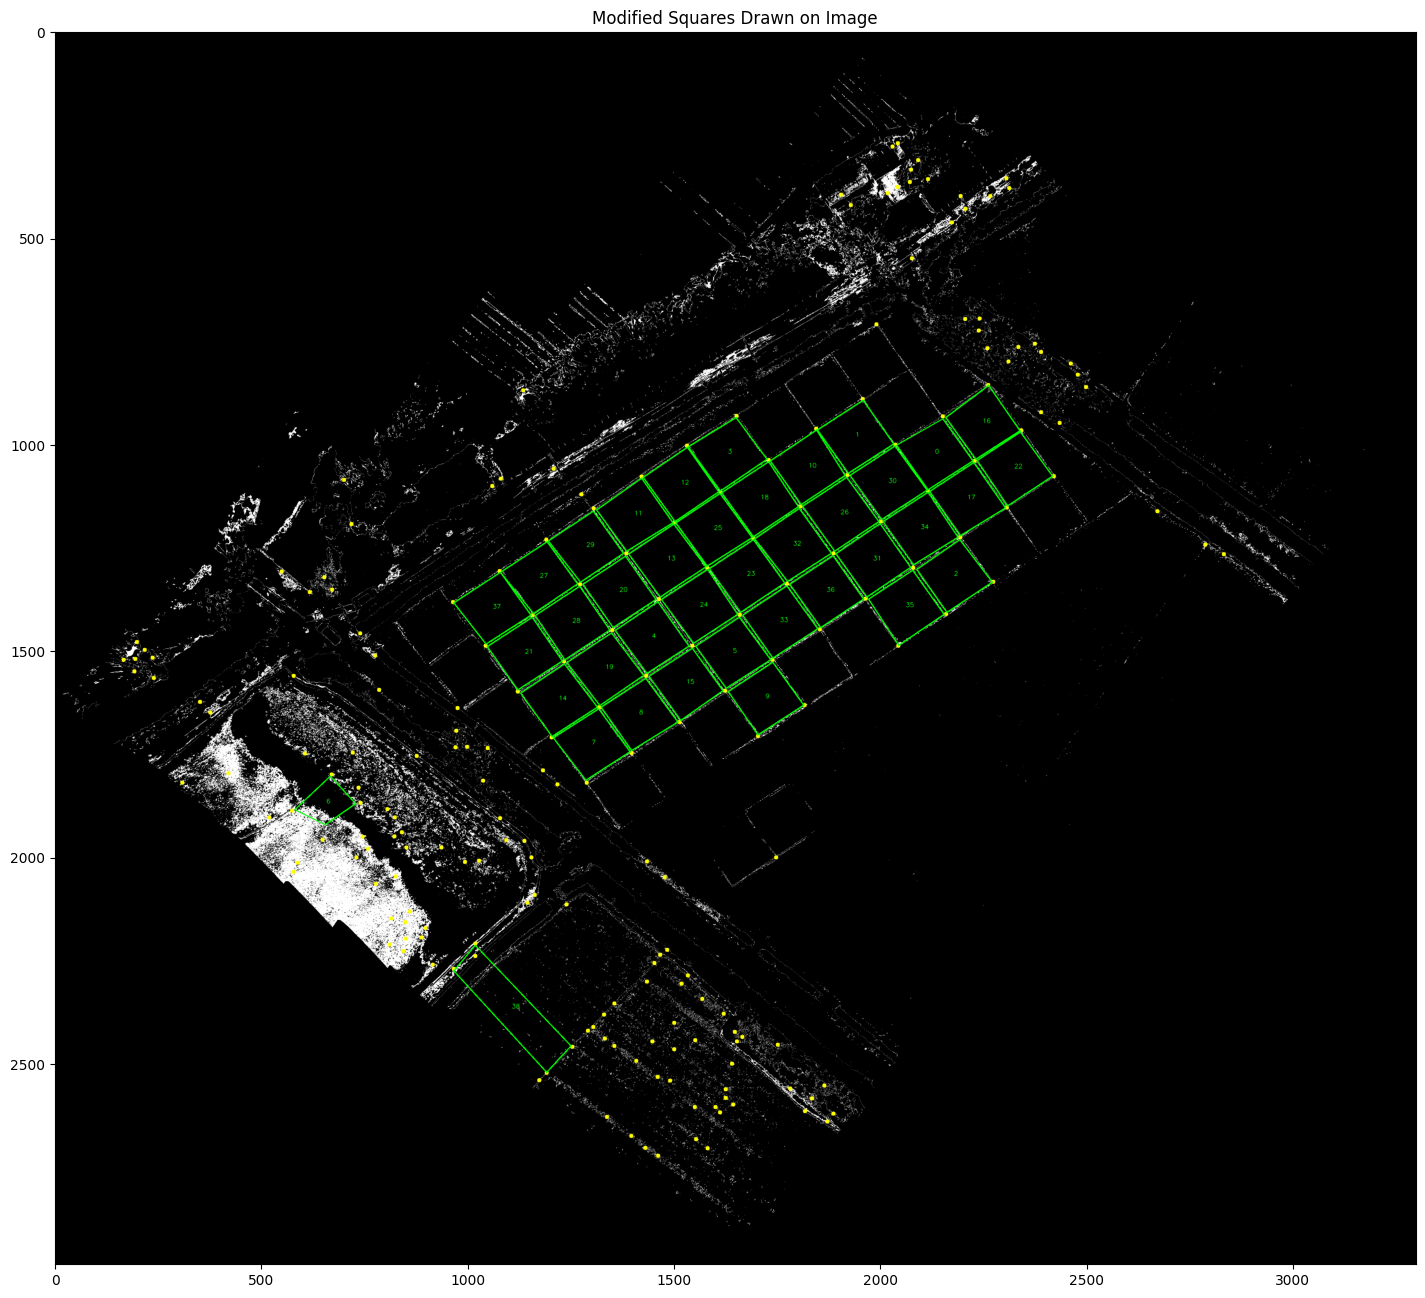

Cropping and saving completed.


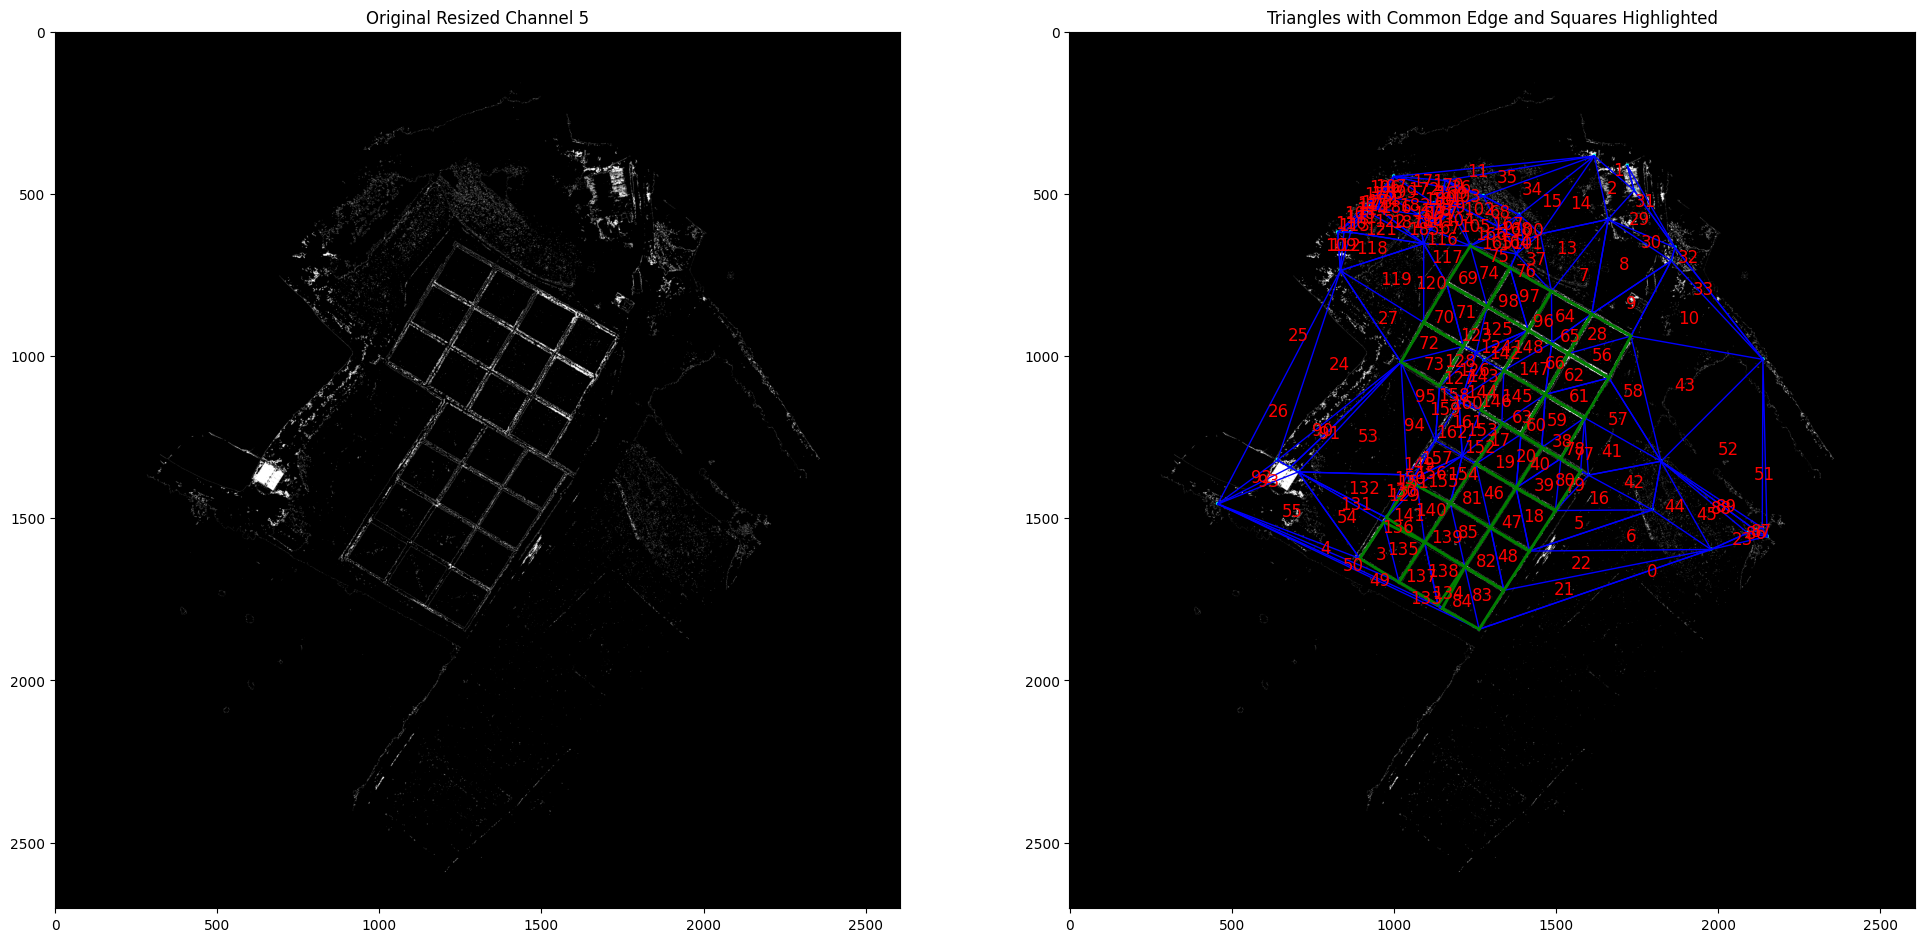

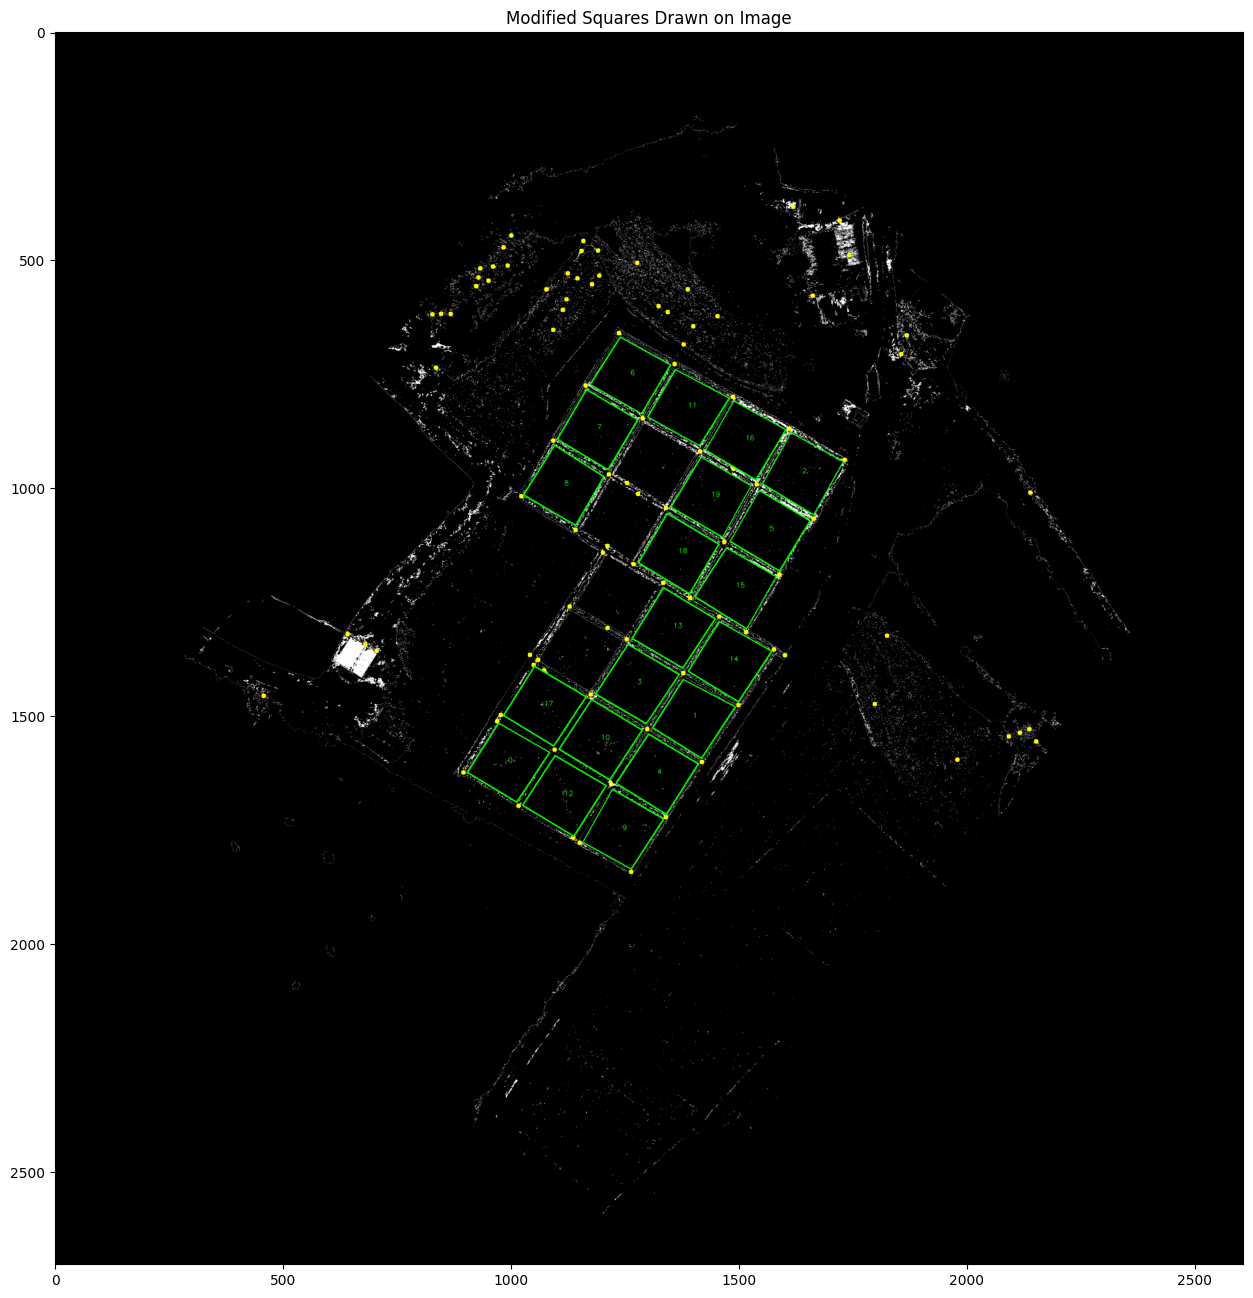

Cropping and saving completed.
All CSV files have been merged into one.


100697

: 

In [25]:
import csv

# List of TIFF files to process
file_paths = [
    'Image_multi_spectral/Multi_4Cm_Ortho_20220326.tif',
    'Image_multi_spectral/Multi_4Cm_Ortho_20220913.tif',
    # Add more file paths here
]

# Process each file and write to a single CSV
global_id = 0
merged_csv_path = os.path.join("cropped_images", "merged_cropped_images_data.csv")
with open(merged_csv_path, mode='w', newline='') as merged_csv_file:
    csv_writer = csv.writer(merged_csv_file)
    # Write the header
    csv_writer.writerow(["id", "image_path", "mask_path", "empty", "segmentation", "k", "fold"])

    for file_path in file_paths:
        square_after_modified, cropped_channel_5 = process_tiff_file(file_path)
        file_name_prefix = os.path.splitext(os.path.basename(file_path))[0]
        global_id = cut_square(square_after_modified, cropped_channel_5, file_name_prefix, csv_writer, global_id)

print("All CSV files have been merged into one.")

import gc
gc.collect()

---
# importance

In [5]:
import os
import tifffile as tiff
import numpy as np

def convert_tiff_to_5_channels(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".tif") or file_name.endswith(".tiff"):
            file_path = os.path.join(input_folder, file_name)
            try:
                # Read the TIFF file
                image = tiff.imread(file_path)
                # Check if the image has 6 channels
                if image.ndim == 3 and image.shape[0] == 6:
                    # Remove the last channel
                    image_5_channels = image[:5, :, :]
                    
                    # Save the new image with 5 channels
                    output_path = os.path.join(output_folder, file_name)
                    tiff.imwrite(output_path, image_5_channels)
                    print(f"Converted {file_name} to 5 channels and saved to {output_path}")
                else:
                    print(f"{file_name} does not have 6 channels, skipping.")
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

# Define input and output folders
input_folder = 'cropped_images\Multi_4Cm_Ortho_20220913'
output_folder = 'cropped_5\Multi_4Cm_Ortho_20220913'

# Convert TIFF files
convert_tiff_to_5_channels(input_folder, output_folder)


Converted cropped_image_0.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_0.tiff
Converted cropped_image_1.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_1.tiff
Converted cropped_image_10.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_10.tiff
Converted cropped_image_11.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_11.tiff
Converted cropped_image_12.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_12.tiff
Converted cropped_image_13.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_13.tiff
Converted cropped_image_14.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_14.tiff
Converted cropped_image_15.tiff to 5 channels and saved to cropped_5\Multi_4Cm_Ortho_20220913\cropped_image_15.tiff
Converted cropped_image_16.tiff to 5 channels and saved to cropped_5\Multi_4

transform tiff file

In [8]:
import os
import cv2
import numpy as np
import tifffile as tiff

def read_images(tiff_file, mask_file):
    image = tiff.imread(tiff_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    return image, mask

def get_perspective_transform(image, mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("No contours found in the mask.")
    
    # Get the largest contour
    contour = max(contours, key=cv2.contourArea)

    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) != 4:
        raise ValueError("The largest contour is not a quadrilateral.")

    # Order the points in the contour
    pts = approx.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # Compute the width and height of the new image
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    # Set up the destination points for the perspective transform
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    # Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def save_transformed_image(output_path, transformed_image):
    tiff.imwrite(output_path, transformed_image)

def process_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".tiff") or file_name.endswith(".tif"):
            tiff_file = os.path.join(input_folder, file_name)
            mask_file = os.path.join(input_folder, file_name.replace("cropped_image", "mask_image").replace(".tiff", ".jpg").replace(".tif", ".jpg"))
            if os.path.exists(mask_file):
                try:
                    # Read the images
                    image, mask = read_images(tiff_file, mask_file)

                    # Transpose the image
                    image = np.transpose(image, (1, 2, 0))

                    # Apply perspective transform
                    transformed_image = get_perspective_transform(image, mask)

                    # Transpose the image back before saving
                    transformed_image = np.transpose(transformed_image, (2, 0, 1))

                    # Save the transformed image
                    output_file = os.path.join(output_folder, file_name)
                    save_transformed_image(output_file, transformed_image)

                    print(f"Transformed image saved to {output_file}")
                except Exception as e:
                    print(f"Error processing {file_name}: {e}")
            else:
                print(f"Mask file for {file_name} does not exist, skipping.")

# Define the input and output folders
input_folder = 'cropped_images\Multi_4Cm_Ortho_20220913'
output_folder = 'transform\Multi_4Cm_Ortho_20220913'

# Process all TIFF files in the folder
process_folder(input_folder, output_folder)


Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_0.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_1.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_10.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_11.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_12.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_13.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_14.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_15.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_16.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_17.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_18.tiff
Transformed image saved to transform\Multi_4Cm_Ortho_20220913\cropped_image_19

CCA

In [21]:
import tifffile as tiff
import numpy as np
import cv2
import os

def normalize_image(image):
    """
    Normalize the image to the range [0, 255].
    """
    image = image.astype(np.float32)
    min_val = image.min(axis=(1, 2), keepdims=True)
    max_val = image.max(axis=(1, 2), keepdims=True)
    normalized_image = 255 * (image - min_val) / (max_val - min_val)
    return normalized_image.astype(np.uint8)

def apply_cca(image):
    # Normalize the image
    image = normalize_image(image)

    # Transpose the image to get shape (height, width, channels)
    image = np.transpose(image, (1, 2, 0))
    num_channels = image.shape[2]
    labeled_images = []

    for i in range(num_channels):
        # Convert channel to binary image (thresholding can be adjusted as needed)
        _, binary = cv2.threshold(image[:, :, i], 50, 255, cv2.THRESH_BINARY)
        
        # Apply connected components
        num_labels, labels_im = cv2.connectedComponents(binary.astype(np.uint8))
        
        # Append labeled image to the list
        labeled_images.append(labels_im)

    # Stack labeled images along the channel dimension to get the final result
    final_image = np.stack(labeled_images, axis=-1)
    final_image = np.transpose(final_image, (2, 0, 1))

    return final_image

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for filename in os.listdir(input_folder):
        if filename.endswith('.tiff'):
            image_path = os.path.join(input_folder, filename)
            image = tiff.imread(image_path)
            
            if image is None:
                print(f"Skipping file {filename}, could not read the image.")
                continue
            
            if image.ndim != 3 or image.shape[0] != 5:
                print(f"Skipping file {filename}, it does not have the expected shape (5, height, width).")
                continue
            
            try:
                result_image = apply_cca(image)
                
                # Save the result image as a TIFF file
                output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.tiff')
                tiff.imwrite(output_path, result_image)
                print(f"Processed and saved: {output_path}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

# Define the input and output folders
input_folder = 'cropped_images/Multi_4Cm_Ortho_20220326'
output_folder = 'cropped_images_CCA/Multi_4Cm_Ortho_20220326'

# Process all TIFF files in the folder
process_folder(input_folder, output_folder)


Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_0.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_1.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_10.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_11.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_12.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_13.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_14.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_15.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_16.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_17.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_18.tiff
Processed and saved: cropped_images_CCA/Multi

C:\Users\longh\AppData\Local\Temp\ipykernel_4684\826583195.py:13: RuntimeWarning: invalid value encountered in divide
  normalized_image = 255 * (image - min_val) / (max_val - min_val)
C:\Users\longh\AppData\Local\Temp\ipykernel_4684\826583195.py:14: RuntimeWarning: invalid value encountered in cast
  return normalized_image.astype(np.uint8)


Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_38.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_4.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_5.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_6.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_7.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_8.tiff
Processed and saved: cropped_images_CCA/Multi_4Cm_Ortho_20220326\cropped_image_9.tiff


C:\Users\longh\AppData\Local\Temp\ipykernel_4684\826583195.py:13: RuntimeWarning: divide by zero encountered in divide
  normalized_image = 255 * (image - min_val) / (max_val - min_val)


In [22]:
import tifffile as tiff
import matplotlib.pyplot as plt
import os

def show_first_image(input_folder, output_folder):
    # Find the first image in the input folder
    input_image_path = None
    for filename in os.listdir(input_folder):
        if filename.endswith('.tiff'):
            input_image_path = os.path.join(input_folder, filename)
            break

    # Find the first image in the output folder
    output_image_path = None
    for filename in os.listdir(output_folder):
        if filename.endswith('.tiff'):
            output_image_path = os.path.join(output_folder, filename)
            break

    if input_image_path and output_image_path:
        # Read the input image
        input_image = tiff.imread(input_image_path)
        
        # Read the output image
        output_image = tiff.imread(output_image_path)

        # Display the input image
        fig, axes = plt.subplots(2, max(input_image.shape[0], output_image.shape[0]), figsize=(15, 10))
        fig.suptitle('Comparison of First Image in Input and Output Folders', fontsize=16)

        # Display each channel of the input image
        for i in range(input_image.shape[0]):
            ax = axes[0, i]
            ax.imshow(input_image[i], cmap='gray')
            ax.set_title(f'Input Channel {i+1}')
            ax.axis('off')

        # Display each channel of the output image
        for i in range(output_image.shape[0]):
            ax = axes[1, i]
            ax.imshow(output_image[i], cmap='gray')
            ax.set_title(f'Output Channel {i+1}')
            ax.axis('off')

        plt.show()
    else:
        print("Could not find valid images in one or both folders.")

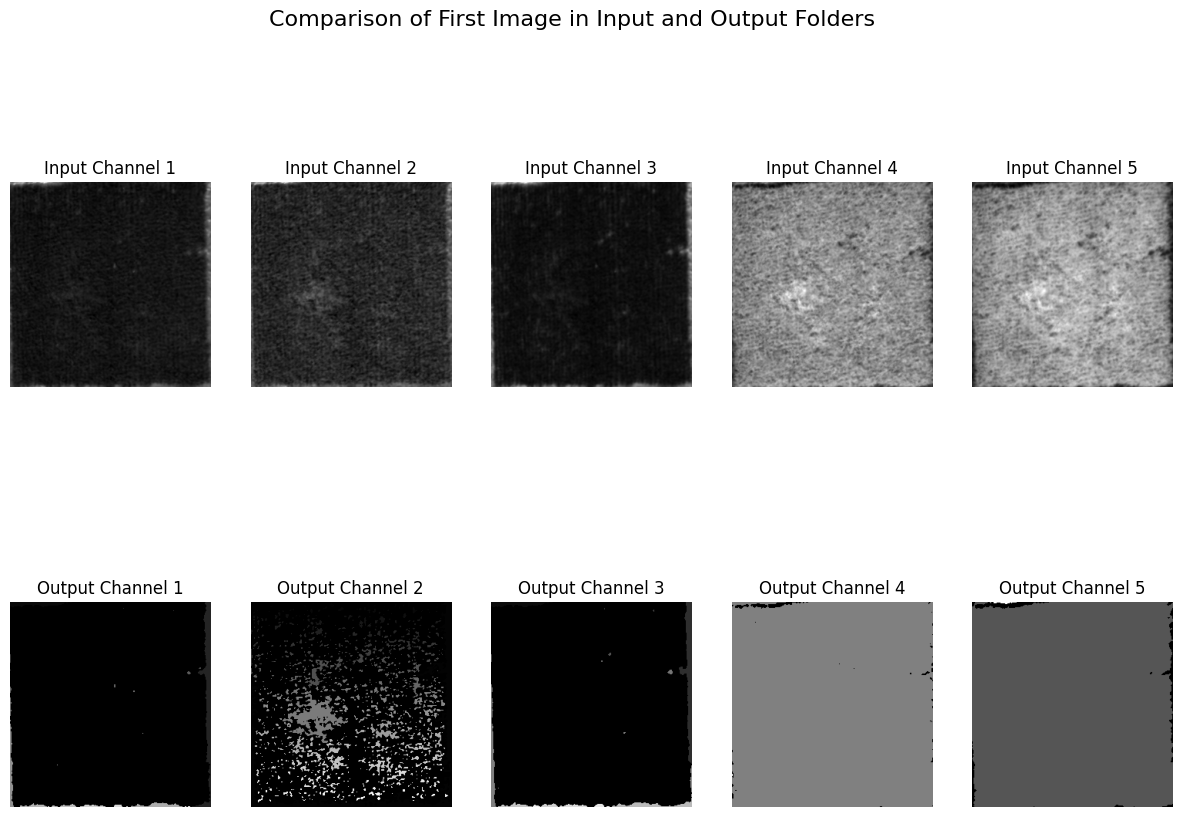

In [23]:
import tifffile as tiff
import matplotlib.pyplot as plt
import os

def show_first_image(input_folder, output_folder):
    # Find the first image in the input folder
    input_image_path = None
    for filename in os.listdir(input_folder):
        if filename.endswith('.tiff'):
            input_image_path = os.path.join(input_folder, filename)
            break

    # Find the first image in the output folder
    output_image_path = None
    for filename in os.listdir(output_folder):
        if filename.endswith('.tiff'):
            output_image_path = os.path.join(output_folder, filename)
            break

    if input_image_path and output_image_path:
        # Read the input image
        input_image = tiff.imread(input_image_path)
        # Read the output image
        output_image = tiff.imread(output_image_path)

        # Display the input image
        fig, axes = plt.subplots(2, max(input_image.shape[0], output_image.shape[0]), figsize=(15, 10))
        fig.suptitle('Comparison of First Image in Input and Output Folders', fontsize=16)

        # Display each channel of the input image
        for i in range(input_image.shape[0]):
            ax = axes[0, i]
            ax.imshow(input_image[i], cmap='gray')
            ax.set_title(f'Input Channel {i+1}')
            ax.axis('off')

        # Display each channel of the output image
        for i in range(output_image.shape[0]):
            ax = axes[1, i]
            ax.imshow(output_image[i], cmap='gray')
            ax.set_title(f'Output Channel {i+1}')
            ax.axis('off')

        plt.show()
    else:
        print("Could not find valid images in one or both folders.")


show_first_image(input_folder, output_folder)